# Task Description
Suppose you are working on a project for a pharmaceutical company. The company wants to monitor the sales team's
daily activities. You've already performed discovery and prepared the initial mock-ups for the dashboard. Now, you
need to assess the client's initial data to make sure it is sufficient for calculating the required metrics and KPIs

Check to make sure the following KPIs can be calcualted:
- Average time from first contact with a client to
signing a deal
- Average number of calls per salesperson with
one client, from first contact to signing a deal
- Customer coverage (number of customers
covered / number of customers in the plan)

Outcomes:
Provide the results of your work in an Excel table. You can find an example below, but keep in mind that you can adjust
the table to your specific needs.

|Check no.|Check type|Entity|Check description|SQL/formula used|Result|
|---|---|---|---|---|---|
|...|...|...|...|...|...|

# Solution
Let's identify attributes that we need to check in detail for calculating KPIs. 
1. Explore Data 
2. Define attributes for calculating KPI 
3. Create a list of attributes

## Explore Data

In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import duckdb
import iplantuml
from datetime import datetime
import numpy as np

In [58]:
# read data from the spreadsheets

## call table
calls_df = pd.read_excel("profiling_dataset.xlsx", sheet_name="Calls_table", header=0)

## sales_df
sales_people_df = pd.read_excel("profiling_dataset.xlsx", sheet_name="Sales_people_table", header=0)

## customer table
customer_df = pd.read_excel("profiling_dataset.xlsx", sheet_name="Customer_table", header=0)

In [3]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Sales_Person_ID    4435 non-null   int64         
 1   Customer_ID        4435 non-null   int64         
 2   Call_Date_UTC      4435 non-null   datetime64[ns]
 3   Call_Duration_Sec  4435 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 138.7 KB


In [4]:
sales_people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Sales_Person_ID       150 non-null    int64 
 1   Sales_Person_Name     150 non-null    object
 2   Sales_Person_Country  150 non-null    object
 3   Sales_Person_City     112 non-null    object
 4   Sales_Person_Address  115 non-null    object
dtypes: int64(1), object(4)
memory usage: 6.0+ KB


In [5]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Customer_ID        1228 non-null   int64 
 1   Customer_Category  1034 non-null   object
 2   Customer_Name      1220 non-null   object
 3   Customer_Phone     929 non-null    object
 4   Customer_Address   1128 non-null   object
 5   Customer_City      1017 non-null   object
 6   Date_of_Agreement  285 non-null    object
dtypes: int64(1), object(6)
memory usage: 67.3+ KB


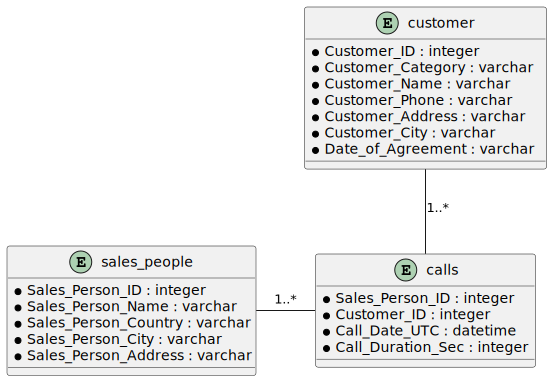

In [6]:
%%plantuml

@startuml

entity calls {
    * Sales_Person_ID : integer
    * Customer_ID : integer
    * Call_Date_UTC : datetime
    * Call_Duration_Sec : integer
}

entity sales_people {
    * Sales_Person_ID : integer
    * Sales_Person_Name : varchar
    * Sales_Person_Country : varchar
    * Sales_Person_City : varchar
    * Sales_Person_Address : varchar
}

entity customer {
    * Customer_ID : integer
    * Customer_Category : varchar
    * Customer_Name : varchar
    * Customer_Phone : varchar
    * Customer_Address : varchar
    * Customer_City : varchar
    * Date_of_Agreement  : varchar
}

sales_people - calls : 1..*
customer -- calls : 1..*



@enduml

## Data Profiling

### Calls Table Profiling Overview

In [7]:
calls_profiling = ProfileReport(calls_df, title="Calls Profiling Report")

In [59]:
calls_profiling.to_notebook_iframe()

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Customer Table Profiling Overview

In [9]:
customer_profiling = ProfileReport(customer_df, title="Customers Profiling Report")

In [60]:
customer_profiling.to_notebook_iframe()

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Check unsupported type in the [Customer].[Date of Agreement] 

In [11]:
# create a function to check if value belongs to datetime
def check_not_date(date_field):
    result = []
    for value in date_field:
        if 'datetime.datetime' not in str(type(value)):
            if  value is not np.nan:
                result.append(value)
    return result


In [12]:
# apply function to define not date types
excluded_values = check_not_date(customer_df['Date_of_Agreement'])

# create excluded dataframe
excluded_df = pd.DataFrame({'values':excluded_values})

In [30]:
# display excluded values
excluded_df

values
0       u6568
1     *******
2   #$#64ey4r
3     *******
4      bfre3h
5    any date
6    any date
7       47357
8     *******
9     **34656
10     464654
11        325
12    *******
13    *******

### Sales People table Profiling Overview

In [27]:
sales_people_profiling = ProfileReport(sales_people_df, title="Sales People Profiling Report")

In [61]:
sales_people_profiling.to_notebook_iframe()

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Create Profiling Report

In [14]:
def create_profiling_report(df:pd.DataFrame) -> pd.DataFrame:
    # create columns list
    columns_list = df.columns.to_list()
    #create placeholders
    attributes_list = []
    missed_prc_list = []
    nullable_list = []
    unique_list = []
    occupancy_list = []
    distinct_list = []
    max_list = []
    min_list = []
    avg_list = []
    length_list = []
    case_sens_list = []
    example_list = []
    dtype_list = []

    for col in columns_list:
        #replace null to None
        df[col] = df[col].map(lambda x: None if str(x) == 'null' else x)

        #add attribute to list
        attributes_list.append(col)

        #calculate nullables values
        total_nullable = df[col].isnull().sum()

        #calculate total values
        total_values = len(df[col])

        #calculate missed values
        missed_values = round((total_nullable * 100 / total_values),2)
        missed_prc_list.append(str(missed_values)+"%")
            
        #define nullable fields
        if missed_values != 0.0:
            nullable = "yes"
        else:
            nullable = "no"
        nullable_list.append(nullable)

        #define total distinct values
        distinct = round(len(df.loc[~df[col].isnull(), col].unique()) * 100/ len(df[col]),2)
        distinct_list.append(str(distinct) + "%")

        #define uniqueness
        if distinct != 100.0:
            unique = "no"
        else:
            unique = "yes"
        unique_list.append(unique)

        #define occupancy rate
        occupancy = round(100 - missed_values, 2)
        occupancy_list.append(str(occupancy)+"%")

        #define max, min, average values
        if np.dtype(df[col]) != 'object':
            max_value = df[col].max()
            min_value = df[col].min()
            if  np.dtype(df[col]) != "M8[ns]":
                avg_value = round(df[col].mean(),2)
            else:
                avg_value = "n/a"
        else:
            max_value = "n/a"
            min_value = "n/a"
            avg_value = "n/a"
        max_list.append(max_value)
        min_list.append(min_value)
        avg_list.append(avg_value)

        #define case sensitive columns
        case_list = [] 
        if np.dtype(df[col]) == 'object':
            for val in df[col]:
                if str(val).isdigit() == False and len(str(val)) >= 1:
                    if str(val)[0].isupper():
                        case_s = "no"
                    for i in range(1, len(str(val))):
                        if str(val)[i].islower():
                            case_s = "yes"
                        break
                    else:
                        case_s = "no"
                    for i in range(1, len(str(val))):
                        if str(val)[i].isupper():
                            case_s = "yes"
                        break
                else:
                    case_s = "n/a"
                    break
                case_list.append(case_s)
                if case_list.count("no") == len(df):
                    case_sens = "no"
                elif case_list.count("n/a") == len(df):
                    case_sens = "n/a"
                else:
                    case_sens = "yes"
        else:
            case_sens = "n/a"
        case_sens_list.append(case_sens)

        #define length
        if np.dtype(df[col]) == 'object':
            new_length = [str(i) for i in df[col]]
            new_length.sort(reverse=True, key=len)
            length = len(str(new_length[0]))
        else:
            length = len(str(df[col].max()))
        length_list.append(length)

        #data example
        if len(df.loc[~df[col].isnull(), col].to_list()) > 0:
            example_list.append(df.loc[~df[col].isnull(), col].to_list()[0])
        else:
            example_list.append(df[col].to_list()[0])
    
        #define data 
        if np.dtype(df[col]) == 'object':
            dtype_list.append("string")
        else:
            dtype_list.append(str(np.dtype(df[col])))


    data_profiling = pd.DataFrame({
        "Attribute" : attributes_list,
        "Missed values, %" : missed_prc_list,
        "Nullable" : nullable_list,
        "Unique value" : unique_list,
        "Expected datatype" : dtype_list,
        "Occupancy rating" : occupancy_list,
        "Distinct %" : distinct_list,
        "Max value" : max_list,
        "Min value" : min_list,
        "Average value (Mean)" : avg_list,
        "Length" : length_list,
        "Case sensitive" : case_sens_list,
        "Example" : example_list
    })

    return data_profiling

In [15]:
# calls table profiling report
calls_profiling_report = create_profiling_report(calls_df)
calls_profiling_report['Table'] = 'Calls'

# customer table profiling report
customer_profiling_report = create_profiling_report(customer_df)
customer_profiling_report['Table'] = 'Customer'

# sales people profiling report
sales_people_profiling_report = create_profiling_report(sales_people_df)
sales_people_profiling_report['Table'] = 'Sales_People'


In [16]:
# sales people profiling report sample
sales_people_profiling_report

Attribute Missed values, % Nullable Unique value  \
0       Sales_Person_ID             0.0%       no          yes   
1     Sales_Person_Name             0.0%       no           no   
2  Sales_Person_Country             0.0%       no           no   
3     Sales_Person_City           25.33%      yes           no   
4  Sales_Person_Address           23.33%      yes           no   

  Expected datatype Occupancy rating Distinct % Max value Min value  \
0             int64           100.0%     100.0%       150         1   
1            string           100.0%     96.67%       n/a       n/a   
2            string           100.0%      4.67%       n/a       n/a   
3            string           74.67%     13.33%       n/a       n/a   
4            string           76.67%     66.67%       n/a       n/a   

  Average value (Mean)  Length Case sensitive                Example  \
0                 75.5       3            n/a                      1   
1                  n/a      21            yes           Pam Callahan   
2                  n/a      13            yes          United States   
3                  n/a      18            yes              Bradenton   
4                  n/a      34            yes  2355 WEST MAIN STREET   

          Table  
0  Sales_People  
1  Sales_People  
2  Sales_People  
3  Sales_People  
4  Sales_People

In [17]:
# calls profiling report sample
calls_profiling_report

Attribute Missed values, % Nullable Unique value Expected datatype  \
0    Sales_Person_ID             0.0%       no           no             int64   
1        Customer_ID             0.0%       no           no             int64   
2      Call_Date_UTC             0.0%       no           no    datetime64[ns]   
3  Call_Duration_Sec             0.0%       no           no             int64   

  Occupancy rating Distinct %            Max value            Min value  \
0           100.0%      3.38%                  150                    1   
1           100.0%     21.33%                  956                    1   
2           100.0%     99.89%  2021-08-31 23:59:07  1921-08-12 12:38:13   
3           100.0%     13.39%                  598                    0   

  Average value (Mean)  Length Case sensitive              Example  Table  
0                 74.9       3            n/a                   94  Calls  
1               477.79       3            n/a                   75  Calls  
2                  n/a      19            n/a  2021-08-29 03:01:25  Calls  
3               297.21       3            n/a                  568  Calls

In [18]:
# customer profiling report sample
customer_profiling_report

Attribute Missed values, % Nullable Unique value Expected datatype  \
0        Customer_ID             0.0%       no          yes             int64   
1  Customer_Category            15.8%      yes           no            string   
2      Customer_Name            0.65%      yes           no            string   
3     Customer_Phone           24.35%      yes           no            string   
4   Customer_Address            8.14%      yes           no            string   
5      Customer_City           17.18%      yes           no            string   
6  Date_of_Agreement           76.79%      yes           no            string   

  Occupancy rating Distinct % Max value Min value Average value (Mean)  \
0           100.0%     100.0%      1228         1                614.5   
1            84.2%      0.57%       n/a       n/a                  n/a   
2           99.35%      79.4%       n/a       n/a                  n/a   
3           75.65%     71.01%       n/a       n/a                  n/a   
4           91.86%     91.21%       n/a       n/a                  n/a   
5           82.82%      2.36%       n/a       n/a                  n/a   
6           23.21%      7.25%       n/a       n/a                  n/a   

   Length Case sensitive                 Example     Table  
0       4            n/a                       1  Customer  
1       6            yes                   Large  Customer  
2      94            yes  MOWRY MEDICAL PHARMACY  Customer  
3      14            yes            510-793-5011  Customer  
4      39            yes       1999 MOWRY AVENUE  Customer  
5      14            yes                    LODI  Customer  
6      19            yes     2021-09-01 00:00:00  Customer

In [19]:
#merge tables
combined_report = pd.concat([calls_profiling_report, customer_profiling_report, sales_people_profiling_report], ignore_index=True)

In [20]:
# reorder columns
combined_report = combined_report[[
    'Table'
    , 'Attribute'
    , 'Missed values, %'
    , 'Nullable'
    , 'Unique value'
    , 'Expected datatype'
    , 'Occupancy rating'
    , 'Distinct %'
    , 'Max value'
    , 'Min value'
    , 'Average value (Mean)'
    , 'Length'
    , 'Case sensitive'
    , 'Example'
    ]]

In [21]:
# combined profiling report
combined_report

Table             Attribute Missed values, % Nullable Unique value  \
0          Calls       Sales_Person_ID             0.0%       no           no   
1          Calls           Customer_ID             0.0%       no           no   
2          Calls         Call_Date_UTC             0.0%       no           no   
3          Calls     Call_Duration_Sec             0.0%       no           no   
4       Customer           Customer_ID             0.0%       no          yes   
5       Customer     Customer_Category            15.8%      yes           no   
6       Customer         Customer_Name            0.65%      yes           no   
7       Customer        Customer_Phone           24.35%      yes           no   
8       Customer      Customer_Address            8.14%      yes           no   
9       Customer         Customer_City           17.18%      yes           no   
10      Customer     Date_of_Agreement           76.79%      yes           no   
11  Sales_People       Sales_Person_ID             0.0%       no          yes   
12  Sales_People     Sales_Person_Name             0.0%       no           no   
13  Sales_People  Sales_Person_Country             0.0%       no           no   
14  Sales_People     Sales_Person_City           25.33%      yes           no   
15  Sales_People  Sales_Person_Address           23.33%      yes           no   

   Expected datatype Occupancy rating Distinct %            Max value  \
0              int64           100.0%      3.38%                  150   
1              int64           100.0%     21.33%                  956   
2     datetime64[ns]           100.0%     99.89%  2021-08-31 23:59:07   
3              int64           100.0%     13.39%                  598   
4              int64           100.0%     100.0%                 1228   
5             string            84.2%      0.57%                  n/a   
6             string           99.35%      79.4%                  n/a   
7             string           75.65%     71.01%                  n/a   
8             string           91.86%     91.21%                  n/a   
9             string           82.82%      2.36%                  n/a   
10            string           23.21%      7.25%                  n/a   
11             int64           100.0%     100.0%                  150   
12            string           100.0%     96.67%                  n/a   
13            string           100.0%      4.67%                  n/a   
14            string           74.67%     13.33%                  n/a   
15            string           76.67%     66.67%                  n/a   

              Min value Average value (Mean)  Length Case sensitive  \
0                     1                 74.9       3            n/a   
1                     1               477.79       3            n/a   
2   1921-08-12 12:38:13                  n/a      19            n/a   
3                     0               297.21       3            n/a   
4                     1                614.5       4            n/a   
5                   n/a                  n/a       6            yes   
6                   n/a                  n/a      94            yes   
7                   n/a                  n/a      14            yes   
8                   n/a                  n/a      39            yes   
9                   n/a                  n/a      14            yes   
10                  n/a                  n/a      19            yes   
11                    1                 75.5       3            n/a   
12                  n/a                  n/a      21            yes   
13                  n/a                  n/a      13            yes   
14                  n/a                  n/a      18            yes   
15                  n/a                  n/a      34            yes   

                   Example  
0                       94  
1                       75  
2      2021-08-29 03:01:25  
3                      568  
4                        1  
5        

In [31]:
# save profiling report
combined_report.to_excel('BIA_Practice_M8.xlsx')

## Define attributes for calculating KPI

In [22]:
# establish connection to duckdb
conn = duckdb.connect()

In [23]:
#setup jupyter workbook
%load_ext sql

%sql conn

In [24]:
%config SqlMagic.displaylimit = 10

### Average time from first contact with a client to signing a deal

In [25]:
%%sql

WITH first_call AS (
    SELECT 
        Customer_ID 
        , MIN(Call_Date_UTC) AS First_Call_Datetime
    FROM
        calls_df AS cl
    GROUP BY 
        Customer_ID
),

diff_view AS (
    SELECT
        c.Customer_ID
        , DATE_DIFF('day', First_Call_Datetime, CAST(Date_of_Agreement AS datetime)) AS Day_DIFF
    FROM
        customer_df AS c
    INNER JOIN first_call AS f
        ON c.Customer_ID = f.Customer_ID
    WHERE
        Date_of_Agreement IS NOT NULL
        AND Date_of_Agreement NOT IN (SELECT * FROM excluded_df)
)

SELECT 
    ROUND(AVG(CASE WHEN Day_DIFF > 0 THEN Day_DIFF END)) AS pos_dif
FROM
    diff_view

Running query in 'DuckDBPyConnection'

+---------+
| pos_dif |
+---------+
|  4370.0 |
+---------+

### Average number of calls per salesperson with one client, from first contact to signing a deal

In [48]:
%%sql

WITH signing_customers AS (
    SELECT Customer_ID
    FROM
        customer_df
    WHERE
        Date_of_Agreement IS NOT NULL
        AND Date_of_Agreement NOT IN (SELECT * FROM excluded_df)
),

calls_per_sales AS (
    SELECT 
        c.Customer_ID
        , c.Sales_Person_ID
        , COUNT(*) AS total_calls
    FROM
        signing_customers AS sc
    INNER JOIN calls_df AS c
        ON sc.Customer_ID = c.Customer_ID
    GROUP BY
        c.Customer_ID
        , c.Sales_Person_ID
    ORDER BY  
        COUNT(*) DESC
)

SELECT 
    ROUND(AVG(total_calls),2) AS Avg_Calls_Number
FROM
    calls_per_sales




Running query in 'DuckDBPyConnection'

+------------------+
| Avg_Calls_Number |
+------------------+
|       4.34       |
+------------------+

### Customer coverage (number of customers covered / number of customers in the plan) 

In [57]:
%%sql

WITH customers_covered AS (
    SELECT 
        COUNT(DISTINCT c.Customer_ID) AS total_covered
    FROM
        customer_df AS c
    INNER JOIN calls_df AS cl
        ON c.Customer_ID = cl.Customer_ID
),

customers_in_plan AS (
    SELECT 
        COUNT(DISTINCT c.Customer_ID) AS total_covered
    FROM
        customer_df AS c
    WHERE 
        c.Customer_ID NOT IN (SELECT DISTINCT Customer_ID FROM calls_df)
)

SELECT 
    ROUND(cc.total_covered / cp.total_covered, 2) AS customer_coverage
FROM
    customers_covered AS cc
    , customers_in_plan AS cp

Running query in 'DuckDBPyConnection'

+-------------------+
| customer_coverage |
+-------------------+
|        3.35       |
+-------------------+

## Results
It is possible to claculate KPI, but there are some issues that must be fixed:
- There are text values in the Date_of_Agreementcolumn from Customer table that must be replaced as NULL or excluded. Values Like
  ['u6568',
 '*******',
 '#$#64ey4r',
 '*******',
 'bfre3h',
 'any date',
 'any date',
 47357,
 '*******',
 '**34656',
 464654,
 325,
 '*******',
 '*******']
- Date_of_Agreement column from Customer table must be converted to Date
- There are dates in the Date_of_Agreement from the future like '12/17/3091' or from the last century like '2/17/1900'
- There are wierd dates in the Call_Date_UTC from the last century like '8/30/1921'
